In [13]:
! pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/home/geantvert/.local/share/virtualenvs/kernl/bin/python -m pip install --upgrade pip' command.


In [14]:
data = dict()
with open("./data.csv") as f:
    for l in f:
        name, batch, seq_len, latency = l.split(",")
        data[(name, int(batch), int(seq_len))] = float(latency.strip())

In [15]:
speedup = dict()
for (name, batch, seq_len), latency in data.items():
    if name == "Baseline":
        continue
    if seq_len not in [16, 128, 256, 384, 512]:
        continue
    key = ("Baseline", batch, seq_len)
    if key not in data:
        continue
    baseline_latency = data[key]
    if name == "Kernl":
        name = "Kernl (this project)"
    speedup[(name, batch, seq_len)] = baseline_latency / latency

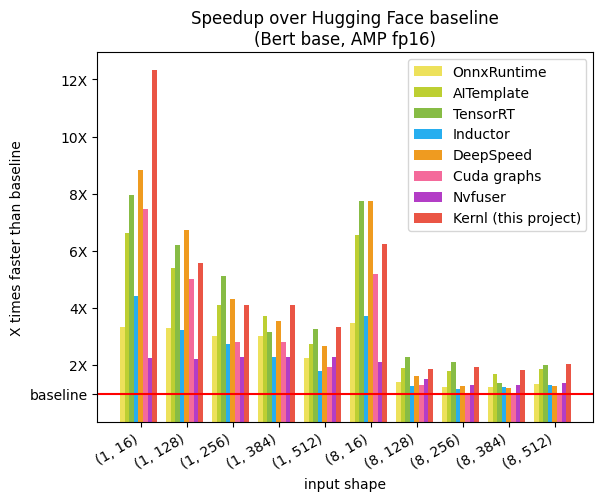

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
width = 0.1

engines = [
    "OnnxRuntime",
    "AITemplate",
    "TensorRT",
    "Inductor",
    "DeepSpeed",
    "Cuda graphs",
    "Nvfuser",
    "Kernl (this project)",
]
colors = ["#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#ef9b20", "#f46a9b", "#b33dc6", "#ea5545", "#edbf33"]

batches = [1, 8]
seq_len = [16, 128, 256, 384, 512]
xticklabels = [f"({b}, {s_l})" for b in batches for s_l in seq_len]
legend_box = list()

for idx_engine, (engine, color) in enumerate(zip(engines, colors)):
    median_latencies = list()

    for b, s_l in [(b, s_l) for b in batches for s_l in seq_len]:
        if (engine, b, s_l) not in speedup:
            continue
        latency = speedup[(engine, b, s_l)]
        median_latencies.append(latency)
    rects = ax.bar([v + idx_engine * width for v in range(len(median_latencies))], median_latencies, width, color=color)
    legend_box.append(rects[0])

ax.axhline(y=1, color="r", linestyle="-")
ax.set_xlabel("input shape")
ax.set_ylabel("X times faster than baseline")
ax.set_title("Speedup over Hugging Face baseline\n(Bert base, AMP fp16)")
ax.set_xticks([v + width * len(engines) / 2 for v in range(len(xticklabels))])
ax.set_xticklabels(xticklabels)
y_ticks = [1] + list(range(2, 13, 2))
ax.set_yticks(y_ticks)
y_ticks_labels = ["baseline"] + [f"{i}X" for i in range(2, 13, 2)]
ax.set_yticklabels(y_ticks_labels)
ax.legend(legend_box, engines)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
plt.show()